In [28]:
# Imports

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 
import os

In [26]:
data = pd.read_csv('../data/data_notscaled.csv')

In [4]:
# Isolating traits from Cat_sex and scaling: 

traits = data.drop(columns=['Cat_sex'])
scaler = StandardScaler()
scaler.fit(traits)
traits_scaled = scaler.transform(traits)
scaled_traits = pd.DataFrame(data=traits_scaled, columns=traits.columns)

As seen in the correlation matrix from the previous notebook, not all traits have correlations with each other. Of the 52 traits, many have a synonomous or similar trait that has a higher correlation with others. I will be using both Principle Component Analysis (PCA) and Factor Analysis (FA) to reduce the dimensionality of the dataset and define the main trait groups and their cotributing traits. 

Procedure:
1. Create an Elbow Plot to find the optimal number of components for PCA and FA 
2. Conduct PCA to find the data's variance structure and the components that have the greatest contribution on variation
3. Analyze the loading matrix and manually drop the least relevant traits
4. Conduct FA to cluster the correlated traits into a smaller number of trait groups for easier interprebility and user input

### 1. Initiating PCA with arbitrary `n_components` for the Elbow Plot

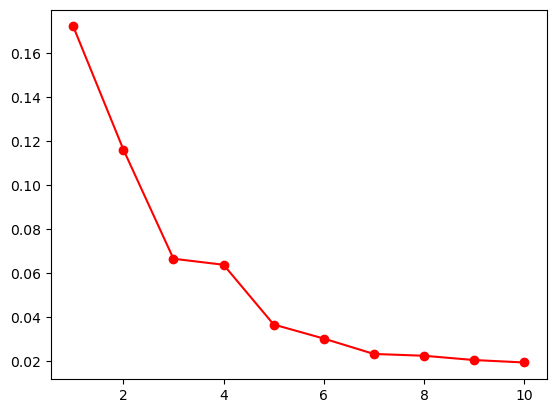

In [5]:
plot_pca = PCA(n_components=10)
plot_pca.fit_transform(scaled_traits)
ev_ratio = plot_pca.explained_variance_ratio_
PC_numbers = np.arange(plot_pca.n_components_) + 1

plt.plot(PC_numbers, ev_ratio, 'ro-')

%matplotlib inline

### 2. PCA

The elbow graph shows a large drop in inertia at k=3 and a smaller drop at k=5. I will be initiating PCA with `n_components = 5` to preserve as much variation in the data as possible. 

In [6]:
pca = PCA(n_components=5)
pc = pca.fit_transform(scaled_traits)
ev_ratio = pca.explained_variance_ratio_

### 3. Dropping low relevance traits  

In [7]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=scaled_traits.columns)

I will find the least relevant traits by calculating the sum of each trait's squared loading across all 5 Principal Components. A larger number means the trait contributes more to the 5 PCs, therefore having a higher impact on on data's variability. 

In [8]:
loadings['weight'] = loadings['PC1'] **2 + loadings['PC2'] **2 + loadings['PC3'] **2 + loadings['PC4'] **2 + loadings['PC5'] **2

In [9]:
loadings.sort_values(by='weight')

,PC1,PC2,PC3,PC4,PC5,weight
Individualistic,0.004940,0.125124,0.079512,0.056391,0.023421,0.025731
Quitting,0.110936,0.015920,-0.151239,0.050552,-0.033919,0.039139
Fearful_other_cats,0.154399,-0.080147,0.080796,0.050317,0.039832,0.040909
Tense,0.208479,0.031058,0.068353,0.037803,0.038352,0.052000
Persevering,-0.079636,0.156293,0.142868,0.029379,0.069965,0.056939
Cool,-0.147648,-0.001351,-0.062753,-0.162188,-0.100381,0.062121
Cooperative,-0.116395,-0.142131,0.093309,0.078074,0.123408,0.063781
Aggressive_to_people,0.108085,0.188723,-0.047658,-0.046360,-0.127678,0.068021
Self_assured,-0.221869,0.102848,0.076325,-0.114640,-0.007992,0.078835
Stable,-0.230839,-0.049491,-0.054879,-0.127081,-0.063051,0.078873


The traits that have the lowest weight could be ones that may be a bit difficult to objectively conceptualize in a cat (ex: `individualistic` & `quitting`), or have a similar trait with higher weight (`fearful_other_cats` & `tense` vs `anxious`). I need to define a weight cutoff threshold to determine if the trait will be removed or not. Visuallizing the weights will allow me to see if there is a natural cutoff where they increase at a sharper angle.

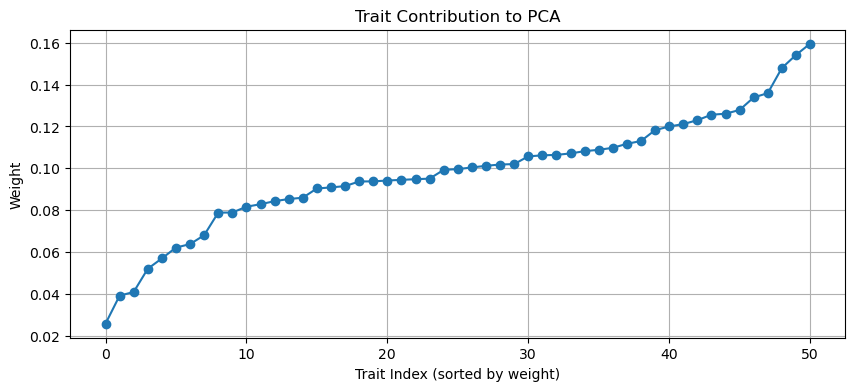

In [10]:
loadings_sorted = loadings.sort_values(by='weight')
plt.figure(figsize=(10, 4))
plt.plot(range(len(loadings_sorted)), loadings_sorted['weight'].values, marker='o')
plt.title('Trait Contribution to PCA')
plt.xlabel('Trait Index (sorted by weight)')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

It seems like there is a sharp increase in weight between 0.06 and 0.08. I will use 0.08 as my cutoff threshold and drop the traits with less weight than the threshold moving forward. 

In [11]:
lowest_weighed = loadings_sorted[loadings_sorted['weight'] < 0.08]
to_drop = pd.Series(lowest_weighed.index)
scaled_traits = scaled_traits.drop(columns=to_drop)
scaled_traits #10 traits were dropped

,Vigilant,Bold,Clumsy,Defiant,Gentle,Constrained,Inquisitive,Inventive,Irritable,Distractable,...,Aggressive_other_cats,Excitable,Friendly_to_people,Playful,Vocal,Decisive,Anxious,Trusting,Active,Shy
0,0.358889,1.448682,1.443501,0.635967,0.442462,-1.843511,-0.136441,-0.449600,0.180849,-0.259260,...,0.865603,1.020277,-0.052126,-0.782620,0.982212,-0.875698,0.523300,0.398524,1.077111,-0.780937
1,1.064416,-0.213254,-0.820236,1.637569,1.055169,-0.616870,-0.760816,-1.007612,-0.372713,0.949164,...,1.939208,1.020277,1.082325,-0.782620,-1.823528,-0.875698,1.669872,0.932723,-2.454485,-0.780937
2,1.064416,1.448682,-0.820236,-0.866437,-1.395661,-0.616870,1.112309,1.224438,-0.372713,-0.863473,...,0.865603,0.418603,-1.186577,1.191668,0.421064,1.389207,-0.049986,-0.135676,1.077111,-0.234755
3,1.064416,-1.875190,-0.820236,1.637569,-2.008369,1.836410,-2.633941,-1.007612,2.395095,-1.467685,...,-0.208001,0.418603,-2.321028,-2.098812,-1.823528,-0.120729,-0.049986,-1.204075,-1.865886,1.403790
4,-0.346637,1.448682,-0.820236,0.135166,1.055169,1.836410,-0.760816,-0.449600,-0.926274,-0.863473,...,-0.744803,-0.784745,1.082325,-0.124524,0.421064,-0.120729,-1.196558,1.466922,1.077111,-0.780937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,-0.346637,-0.213254,-0.820236,-1.367238,-1.395661,0.609770,0.487934,-0.449600,-0.372713,-0.863473,...,0.865603,-0.784745,-1.186577,0.533572,-0.140084,0.634239,-0.623272,-0.135676,1.077111,-0.234755
2760,-0.346637,0.894704,-0.820236,-0.866437,0.442462,1.223090,-1.385191,-1.565625,-0.926274,-0.259260,...,1.939208,-0.784745,1.082325,-2.098812,-1.262380,-0.120729,-1.196558,0.932723,-2.454485,0.311426
2761,0.358889,0.340725,-0.820236,-0.866437,0.442462,-1.230190,-0.136441,0.108413,-0.926274,1.553376,...,-1.281606,-0.183071,-0.052126,0.533572,0.421064,-0.120729,-0.623272,0.398524,-0.100087,-0.780937
2762,0.358889,0.340725,-0.820236,-1.367238,1.055169,-0.003550,-0.136441,0.666425,-0.372713,-0.863473,...,-0.208001,-1.386419,-1.753802,-0.124524,-0.140084,0.634239,-1.196558,-1.204075,-0.100087,0.857608


### 4. Factor Analysis

In [12]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=5, random_state=13) # starting the the same k value as PCA according to my elbow graph
fa1 = fa.fit_transform(scaled_traits.values)

In [13]:
loadings = pd.DataFrame(fa.components_.T, 
                        index=scaled_traits.columns, 
                        columns=[f"Factor{i+1}" for i in range(5)])

In [14]:
loadings.head()

<bound method NDFrame.head of                         Factor1   Factor2   Factor3   Factor4   Factor5
Vigilant               0.008031  0.208730 -0.468033 -0.062143  0.052970
Bold                  -0.546916  0.396513 -0.107532 -0.001075  0.194307
Clumsy                 0.125939 -0.032648  0.227782  0.408811 -0.140521
Defiant               -0.017304  0.667944  0.070045 -0.046635  0.032649
Gentle                -0.353241 -0.498201 -0.095825  0.041608 -0.253196
Constrained            0.045518 -0.358898  0.129374 -0.274035 -0.151908
Inquisitive           -0.470520  0.210709 -0.498794  0.148839 -0.021450
Inventive             -0.376466  0.246956 -0.498886  0.068259 -0.053562
Irritable              0.276642  0.521192  0.156385  0.000037  0.222256
Distractable           0.132793  0.222016  0.027679  0.477489  0.048638
Erratic                0.297845  0.469984  0.081144  0.387763  0.206510
Solitary               0.418628  0.101881  0.064971 -0.165354  0.254242
Impulsive              0.044948  0

It is a bit hard to gauge which traits affect which factor, so I visualize the loadings in a heatmap where red represents a positive impact on a factor and blue represents a negative impact.

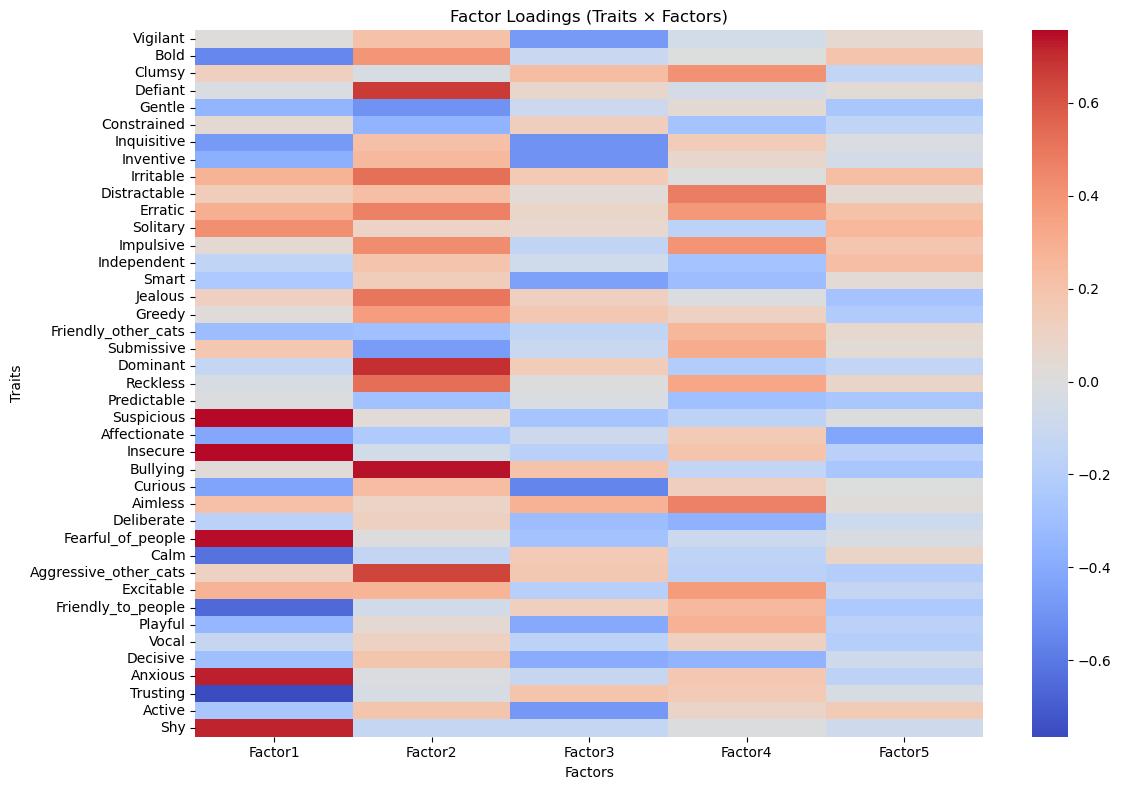

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, cmap='coolwarm', center=0, annot=False)
plt.title("Factor Loadings (Traits × Factors)")
plt.xlabel("Factors")
plt.ylabel("Traits")
plt.tight_layout()
plt.show()

While the visualization shows some clear direction, it also draws attention to the fact that some traits have little impact across all factors, and Factor5 as a whole is not strongly impacted by any trait. I will be dropping traits based on the sum of their squared loading across all 5 factors just like I did for PCA, then refitting my FA with 4 factors instead of 5.

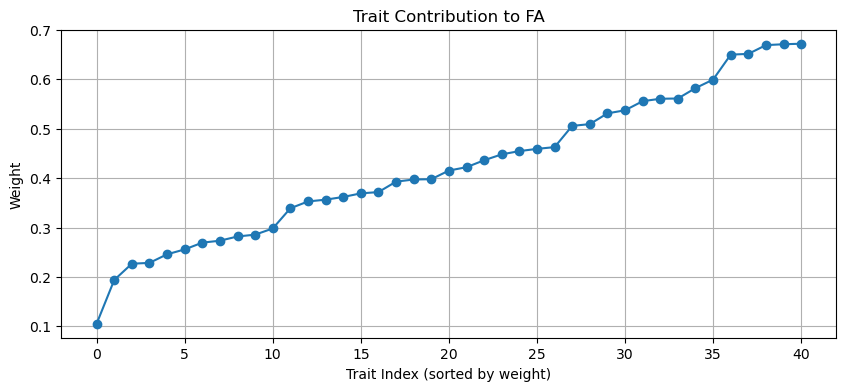

In [16]:
loadings['weight'] = loadings['Factor1'] **2 + loadings['Factor2'] **2 + loadings['Factor3'] **2 + loadings['Factor4'] **2 + loadings['Factor5'] **2
loadings_sorted = loadings.sort_values(by='weight')
plt.figure(figsize=(10, 4))
plt.plot(range(len(loadings_sorted)), loadings_sorted['weight'].values, marker='o')
plt.title('Trait Contribution to FA')
plt.xlabel('Trait Index (sorted by weight)')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

In [17]:
loadings_sorted

,Factor1,Factor2,Factor3,Factor4,Factor5,weight
Vocal,-0.118851,0.112361,-0.164882,0.116300,-0.194505,0.105295
Independent,-0.152619,0.195168,-0.071033,-0.276932,0.225206,0.193837
Greedy,0.023235,0.369720,0.169589,0.104435,-0.223212,0.226723
Predictable,-0.008628,-0.284039,-0.019831,-0.291066,-0.250132,0.228431
Constrained,0.045518,-0.358898,0.129374,-0.274035,-0.151908,0.245788
Clumsy,0.125939,-0.032648,0.227782,0.408811,-0.140521,0.255683
Vigilant,0.008031,0.208730,-0.468033,-0.062143,0.052970,0.269355
Friendly_other_cats,-0.307741,-0.293824,-0.145091,0.260163,0.059401,0.273302
Solitary,0.418628,0.101881,0.064971,-0.165354,0.254242,0.281831
Deliberate,-0.175239,0.120184,-0.309883,-0.370950,-0.082198,0.285540


Similar to what I did in the previous step, I will set the cutoff threshold at 0.35. However, what's different is that I can only drop traits below the threshold that have low impact across all factors. This will prevent me from dropping traits that are very moderate impactful on a singular factor. 

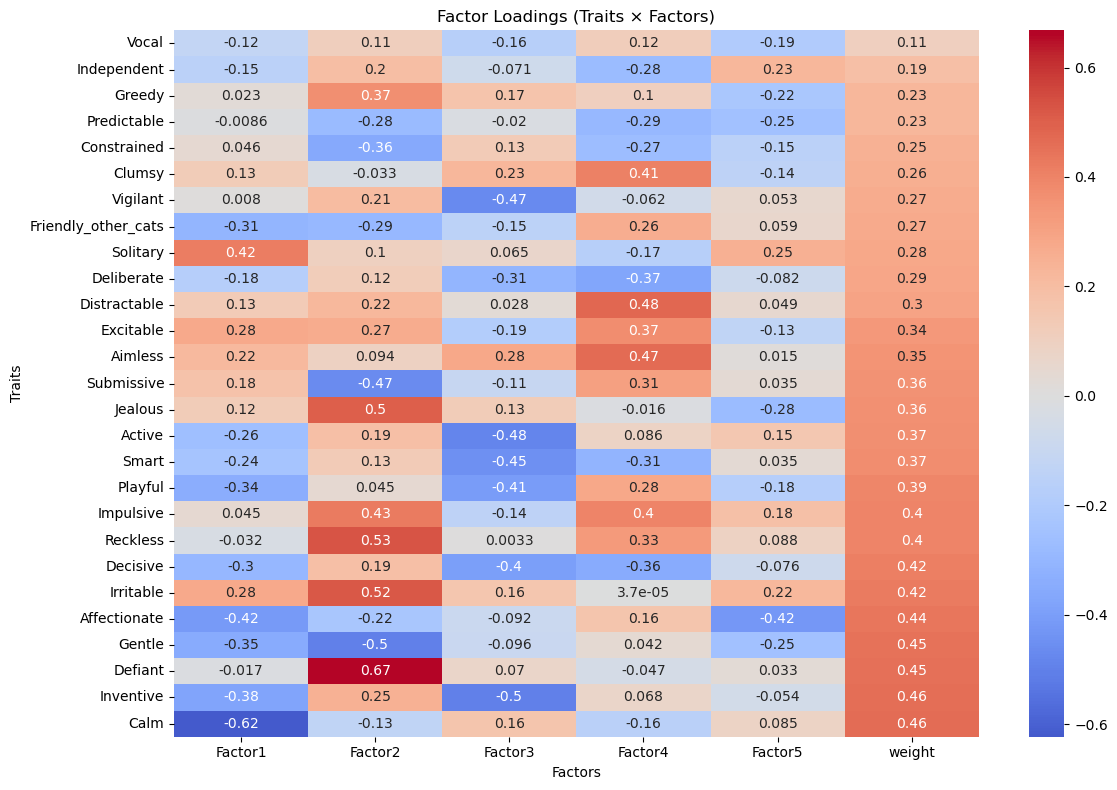

In [18]:
lowest_weighed = loadings_sorted[loadings_sorted['weight'] < 0.5]
plt.figure(figsize=(12, 8))
sns.heatmap(lowest_weighed, cmap='coolwarm', center=0, annot=True)
plt.title("Factor Loadings (Traits × Factors)")
plt.xlabel("Factors")
plt.ylabel("Traits")
plt.tight_layout()
plt.show()

Looking at the heatmap of the least relevant traits, the ones that do not affect any trait in particular and can be safely dropped are `vocal`, `independent`, and `predictable`.

In [19]:
scaled_traits = scaled_traits.drop(columns=(['Vocal', 'Independent', 'Predictable']))

In [20]:
# Redoing FA with 4 factors and less traits 

In [21]:
fa = FactorAnalysis(n_components=4, random_state=10) 
fa1 = fa.fit_transform(scaled_traits.values)

In [22]:
loadings = pd.DataFrame(fa.components_.T, 
                        index=scaled_traits.columns, 
                        columns=[f"Factor{i+1}" for i in range(4)])

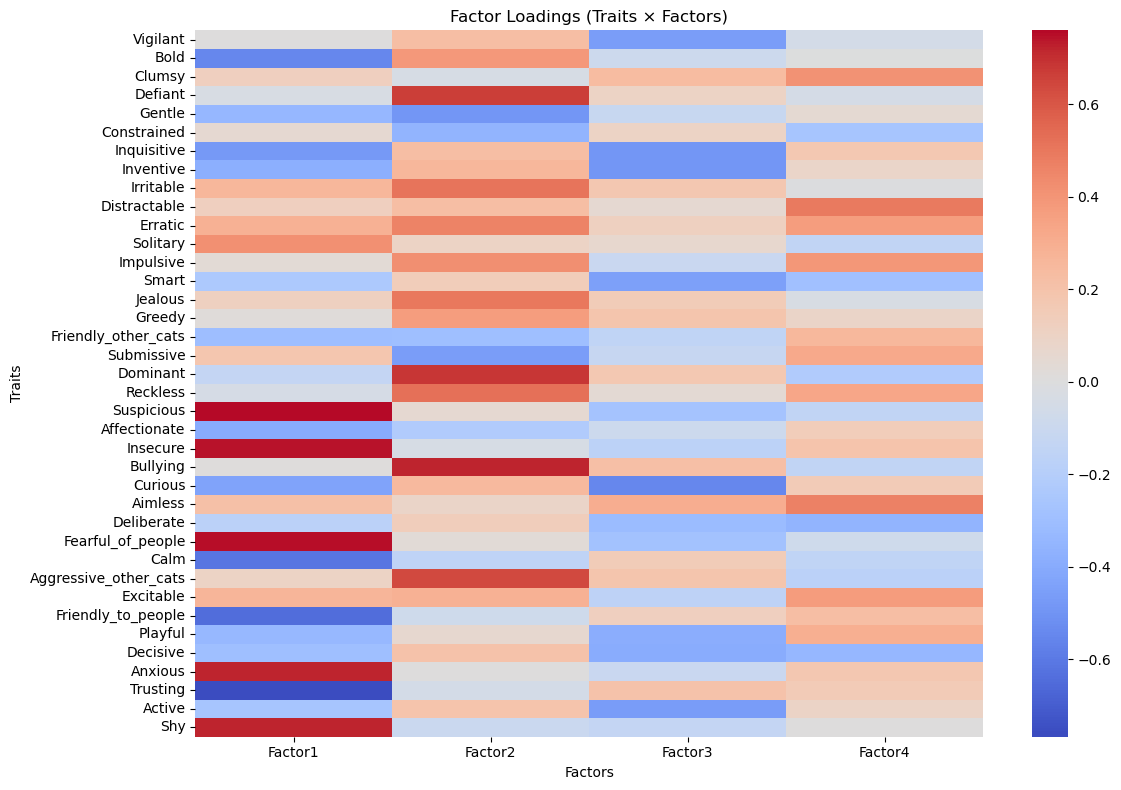

In [23]:
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, cmap='coolwarm', center=0, annot=False)
plt.title("Factor Loadings (Traits × Factors)")
plt.xlabel("Factors")
plt.ylabel("Traits")
plt.tight_layout()
plt.show()

In [48]:
# Reducing all scaled traits into 4 factors:

data_reduced = scaled_traits @ loadings 

In [ ]:
# Adding 'cat_sex' back to the reduced data

The reduced dataset that is ready for the next step is obtained through matrix multiplication of the scaled traits and loadings. The four factors and their representative traits are as follows. 

Factor 1: anxiety/fearfulness/sociability towards humans 

- positive: suspicious, insecure, feaful_of_people, anxious, shy
- negative: bold, inquisitive, calm, friendly_to_people, trusting

Factor 2: dominance/aggression towards other cats 

- positive: defiant, irritable, healous, dominant, reckless, bullying, aggressive_other_cats
- negative: gentle, constrained, friendly_other_cats, submissive

Factor 3: 

- positive: aimless
- negative: vigilant, inquisitive, inventive, smart, curious, playful, decisive, active

Factor 4: 

- positive: clumsy, distractable, erratic, impulsive, aimless, excitable
- negative: constrained, smart, deliberate, decisive 

    

In [49]:
# Saving scaled and reduced data to directory

current_dir = os.getcwd()
main_dir = os.path.abspath(os.path.join(current_dir, '..'))
data_dir = os.path.abspath(os.path.join(main_dir, 'data'))
data_reduced.to_csv(os.path.join(data_dir, 'data_reduced.csv'), index=False)